# Librosa

In [2]:
import librosa
librosa.show_versions()

INSTALLED VERSIONS
------------------
python: 3.10.11 (main, Apr 20 2023, 19:02:41) [GCC 11.2.0]

librosa: 0.8.1

audioread: 3.0.0
numpy: 1.23.5
scipy: 1.10.1
sklearn: 1.2.2
joblib: 1.1.1
decorator: 5.1.1
soundfile: 0.12.1
resampy: 0.4.2
numba: 0.56.4

numpydoc: None
sphinx: None
sphinx_rtd_theme: None
sphinxcontrib.versioning: None
sphinx-gallery: None
pytest: None
pytest-mpl: None
pytest-cov: None
matplotlib: 3.7.1
presets: None


## 读取并可视化

### 波形图 时域分析

在这里，我们绘制了一个简单的音频波形图。 波图让我们知道给定时间的音频响度

长度 = 2.0 秒
长度 = 2.0 秒


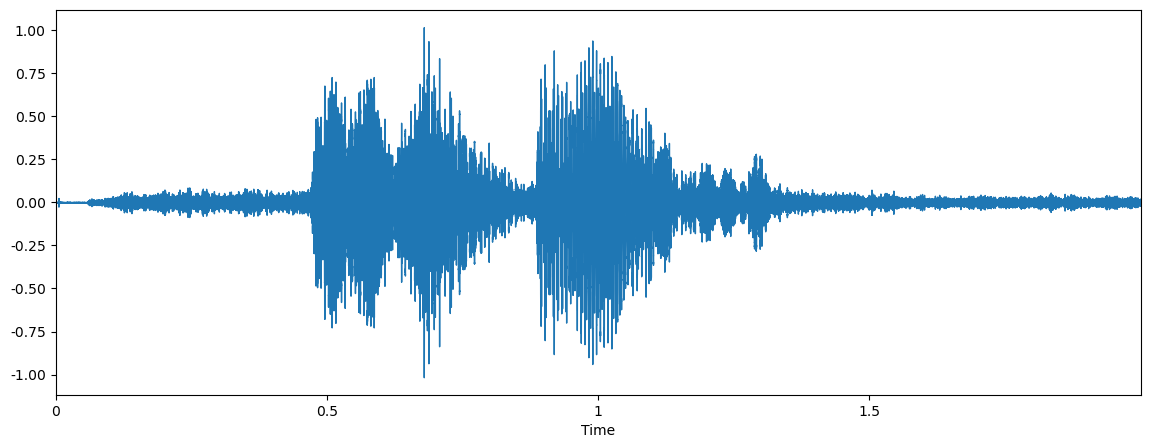

In [4]:
import librosa  # 填充，默认频率为22050，可以改变频率
from scipy.io import wavfile  # 原音无损
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
fs, data = wavfile.read('./data/C2_1_y.wav')  # 原始频率，原始数据
print("长度 = {0} 秒".format(len(data) / fs))
y, sr = librosa.load('./data/C2_1_y.wav')
print("长度 = {0} 秒".format(len(y) / sr))
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr)
plt.show()

### Spectrogram

频谱图（Spectrogram）是声音频率随时间变化的频谱的可视化表示，是给定音频信号的频率随时间变化的表示。'.stft' 将数据转换为短期傅里叶变换。 STFT转换信号，以便我们可以知道给定时间给定频率的幅度。 使用 STFT，我们可以确定音频信号在给定时间播放的各种频率的幅度。

Spectrogram特征是目前在语音识别和环境声音识别中很常用的一个特征，由于CNN在处理图像上展现了强大的能力，使得音频信号的频谱图特征的使用愈加广泛，甚至比MFCC使用的更多。

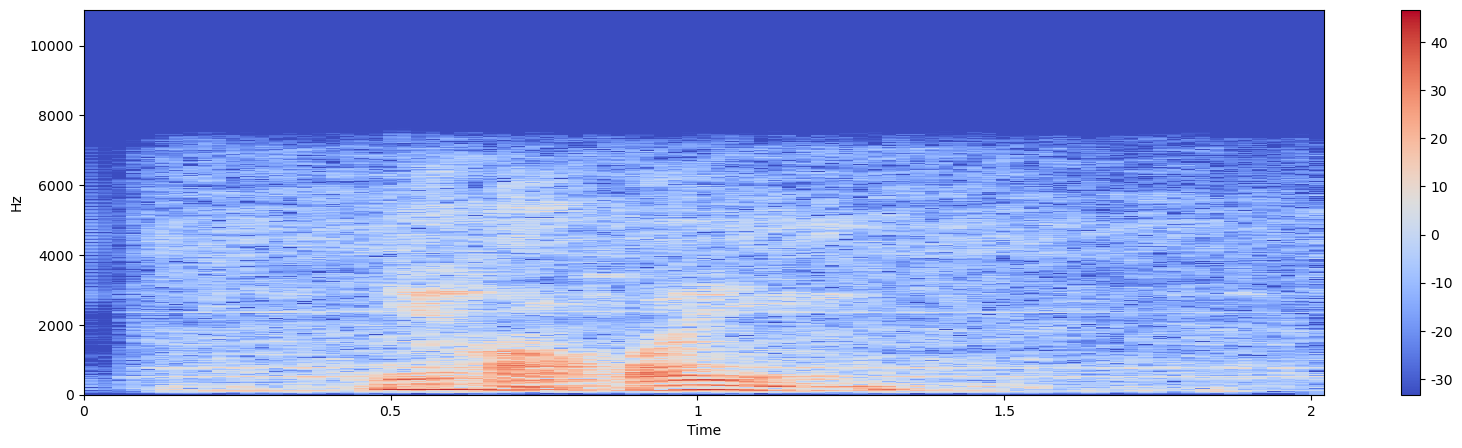

In [5]:
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(20, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.show()

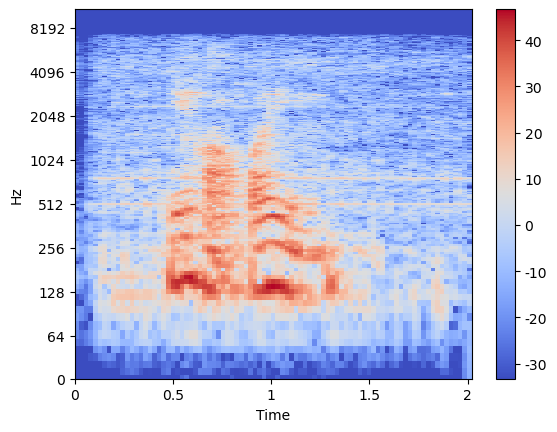

In [6]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

### 梅尔频率倒谱系数（MFCC）

信号的梅尔频率倒谱系数 (MFCC) 是一小组特征（通常约为 10-20），它们简明地描述了频谱包络的整体形状。在 MIR 中，它经常被用来描述音色。

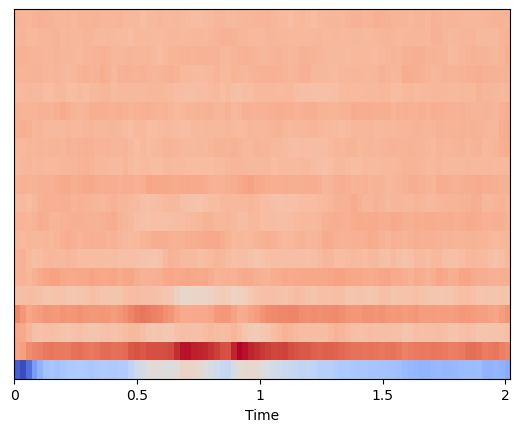

In [12]:
mfccs = librosa.feature.mfcc(y=y, sr=sr)

#mfccs
#
# mfccs.shape

librosa.display.specshow(mfccs, sr=sr, x_axis='time')

### 过零率

过零率（zero-crossing rate，ZCR）是指一个信号的符号变化的比率，例如信号从正数变成负数，或反过来。这个特征已在语音识别和音乐信息检索领域得到广泛使用，是分类敲击声的关键特征。为真时为1，否则为0。在一些应用场景下，只统计“正向”或“负向”的变化，而不是所有的方向。

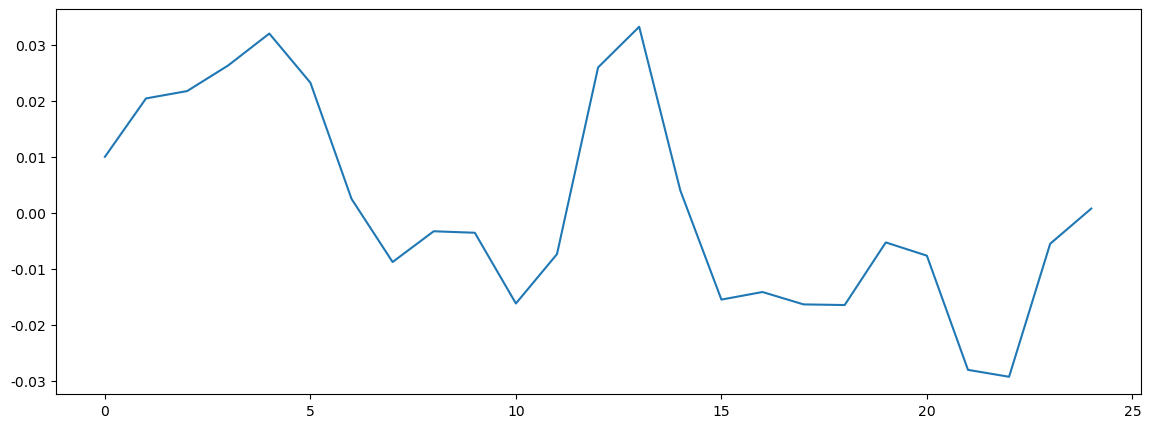

In [14]:
n0 = 7000
n1 = 7025
plt.figure(figsize=(14, 5))
plt.plot(y[n0:n1])
plt.show()

In [17]:
zero_crossings = librosa.zero_crossings(y[n0:n1], pad=False)

zero_crossings.shape

(25,)

In [18]:

zero_crossings.sum()

4

可以使用整个音频来遍历这个并推断出整个数据的过零。

In [20]:
zcrs = librosa.feature.zero_crossing_rate(y)
print(zcrs.shape)

(1, 87)


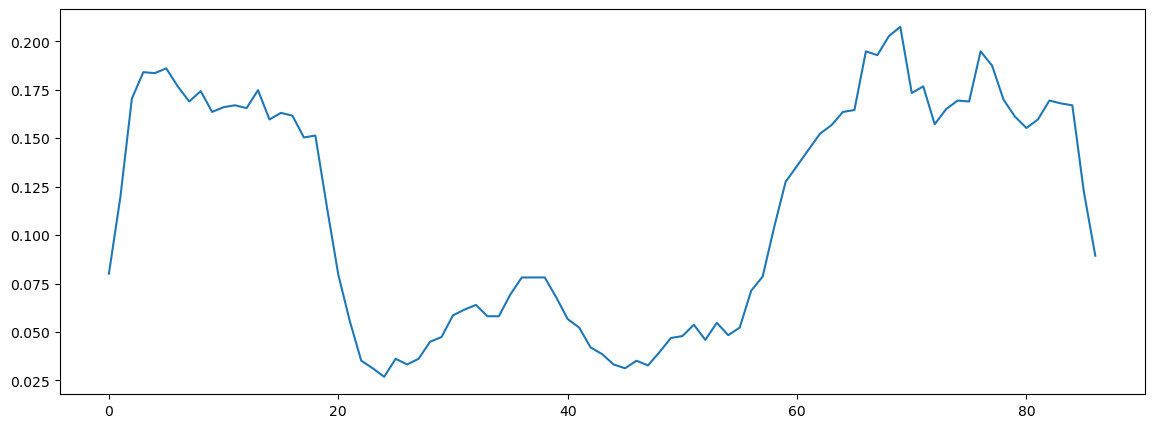

In [21]:
plt.figure(figsize=(14, 5))
plt.plot(zcrs[0])

### 频谱质心： Spectral Centroid

频谱质心（维基百科）表示频谱能量集中在哪个频率上。

In [22]:
spectral_centroids = librosa.feature.spectral_centroid(y, sr=sr)[0]
spectral_centroids.shape

(87,)

In [23]:
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

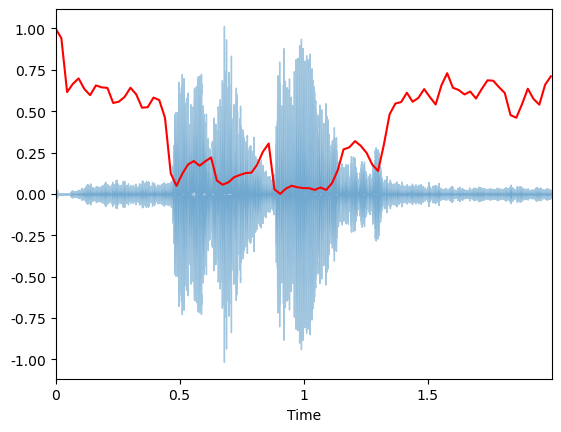

In [25]:
import sklearn
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

librosa.display.waveplot(y, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

### 频谱带宽:Spectral Bandwidth

librosa.feature.spectral_bandwidth 可以用来计算p-order频谱带宽

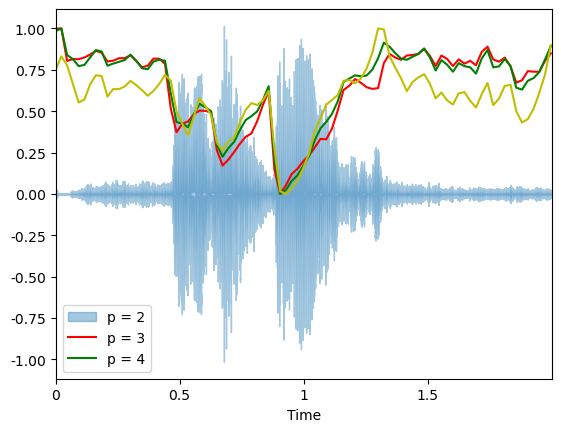

In [27]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=4)[0]
librosa.display.waveplot(y, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

### 频谱滚降

频谱衰减是总频谱能量的特定百分比所在的频率。

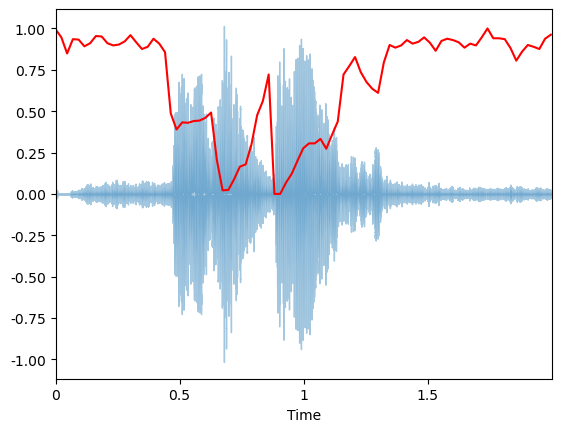

In [29]:
spectral_rolloff = librosa.feature.spectral_rolloff(y+0.01, sr=sr)[0]
librosa.display.waveplot(y, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

### 色度特征：Chroma Feature

色度向量 (Wikipedia) 是一个典型的 12 元素特征向量，指示每个音高类别{C, C#, D, D#, E, ..., B}的能量是多少存在于信号中。

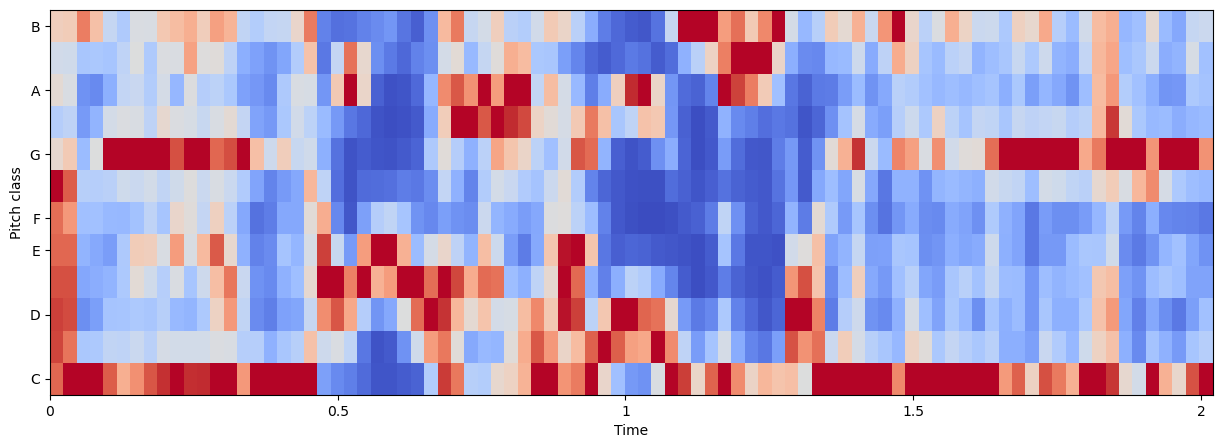

In [30]:
chromagram = librosa.feature.chroma_stft(y, sr=sr, hop_length=512)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')




更多资料可以去查阅：

https://people.csail.mit.edu/hubert/pyaudio/

https://librosa.org/